# Mortgage calculator

This notebook contains some Python code to analyze the two main mortgage types in the Netherlands:
- **Annuity mortgage**: Monthly sum of principal and interest stays constant over time. 
- **Linear mortgage**: Monthly principal stays constant over time.

## Import prerequisites:

In [1]:
from datetime import date
import matplotlib.pyplot as plt
import numpy_financial as npf
import pandas as pd

%load_ext watermark
%watermark -a "gmalim, Extended by: arthurgrava" 
print("")
%watermark -u -n
print("")
%watermark -v -p matplotlib,numpy,pandas
print("")
%watermark -m

Author: gmalim, Extended by: arthurgrava


Last updated: Mon Aug 28 2023


Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.2
numpy     : 1.25.2
pandas    : 2.0.3


Compiler    : GCC 10.2.1 20210110
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : 
CPU cores   : 16
Architecture: 64bit



## Methods

Define annuity and linear mortgage calculation methods:

In [2]:
def create_dataframe(n_years, n_payments_per_year, start_date):
    rng = pd.date_range(start_date, periods=n_years*n_payments_per_year, freq='MS')
    rng.name = "Payment Date"
    column_names = ['Principal', 'Interest', 'Payment', 'Ending Balance']
    df = pd.DataFrame(index=rng, columns=column_names, dtype='float')
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"

    return df

In [3]:
def create_annuity_mortage_data(
    mortgage_value,
    interest_rate,
    n_years,
    n_payments_per_year,
    df
): 
    interest_rate_per_period = interest_rate / n_payments_per_year
    n_payments = n_years * n_payments_per_year
    
    df["Principal"] = -1 * npf.ppmt(interest_rate_per_period, df.index, n_payments, mortgage_value)
    df["Interest"] = -1 * npf.ipmt(interest_rate_per_period, df.index, n_payments, mortgage_value)
    df["Payment"] = -1 * npf.pmt(interest_rate_per_period, n_payments, mortgage_value)
    
    df["Ending Balance"] = 0
    df.loc[1, "Ending Balance"] = mortgage_value - df.loc[1, "Principal"]
    for period in range(2, len(df)+1):
        previous_balance = df.loc[period-1, 'Ending Balance']
        principal_paid = df.loc[period, 'Principal']
        df.loc[period, 'Ending Balance'] = previous_balance - principal_paid
    
    return

In [4]:
def create_linear_mortage_data(mortgage_value,
                               interest_rate,
                               n_years,
                               n_payments_per_year,
                               df):
    
    principal_per_period = mortgage_value / n_years / n_payments_per_year
    
    df["Principal"] = principal_per_period

    df["Interest"] = 0
    df["Payment"] = 0
    df["Ending Balance"] = 0
    df.loc[1, "Interest"] = interest_rate / n_payments_per_year * mortgage_value
    df.loc[1, "Payment"] = principal_per_period + df.loc[1, "Interest"]
    df.loc[1, "Ending Balance"] = mortgage_value - df.loc[1, "Principal"]
    for period in range(2, len(df)+1):
        previous_balance = df.loc[period-1, 'Ending Balance']
        interest = interest_rate / n_payments_per_year * previous_balance
        payment = principal_per_period + interest
        df.loc[period, 'Interest'] = interest
        df.loc[period, 'Payment'] = payment
        df.loc[period, 'Ending Balance'] = previous_balance - principal_per_period
    
    return

In [5]:
def calculate_government_return(
    data: pd.DataFrame,
    woz_value: float,
    income: float,
    ownership_tax: float,
    government_return_rate: float,
) -> pd.DataFrame:
    clone = data.copy(deep=True)
    real_income = lambda interest: (income - interest + (ownership_tax * woz_value))
    clone["Return"] = clone["Interest"].apply(lambda interest: (income - real_income(interest)) * government_return_rate)
    clone["Payment Net"] = clone.apply(lambda vals: vals["Payment"] - (vals["Return"] / 12.0), axis=1)
    return clone[["Year", "Payment", "Payment Net", "Principal", "Interest", "Return", "Ending Balance"]]


def combine_yearly(data: pd.DataFrame) -> pd.DataFrame:
    inner_data = data.copy(deep=True)
    inner_data["Year"] = inner_data["Payment Date"].apply(lambda e: e.year)
    grouping = inner_data.groupby(["Year"])
    return pd.DataFrame({
        "Payment": grouping["Payment"].max(),
        "Principal": grouping["Principal"].sum(),
        "Interest": grouping["Interest"].sum(),
        "Ending Balance": grouping["Ending Balance"].min(),
    }).reset_index()

## User input

Choose mortgage value, annual interest rate and duration of the mortgage:

In [6]:
mortgage_value = 530000 # mortgage value in €
woz_value = 585000 # check in https://www.wozwaardeloket.nl/
income = 90000
interest_rate = 0.05 # annual interest rate
ownership_tax = 0.0045 # eigenwoningforfait (tax on owning a house, current (2023) .45%)
govenrment_return_rate = 0.37 # hypotheekrenteaftrek (current (2023) 37% for all brackets)
n_years = 30 # number of mortgage years
n_payments_per_year = 12 # number of payments per year
start_date = (date(2023, 1, 1)) # start date

## Calculate mortgages

In [7]:
df_annuity = create_dataframe(n_years, n_payments_per_year, start_date)

create_annuity_mortage_data(mortgage_value, interest_rate, n_years, n_payments_per_year, df_annuity)

print(df_annuity.round(2))

       Payment Date  Principal  Interest  Payment  Ending Balance
Period                                                           
1        2023-01-01     636.82   2208.33  2845.15       529363.18
2        2023-02-01     639.47   2205.68  2845.15       528723.70
3        2023-03-01     642.14   2203.02  2845.15       528081.56
4        2023-04-01     644.81   2200.34  2845.15       527436.75
5        2023-05-01     647.50   2197.65  2845.15       526789.25
...             ...        ...       ...      ...             ...
356      2052-08-01    2786.61     58.54  2845.15        11263.05
357      2052-09-01    2798.23     46.93  2845.15         8464.83
358      2052-10-01    2809.88     35.27  2845.15         5654.94
359      2052-11-01    2821.59     23.56  2845.15         2833.35
360      2052-12-01    2833.35     11.81  2845.15           -0.00

[360 rows x 5 columns]


In [8]:
yearly_annuity = combine_yearly(df_annuity)
yearly_annuity_with_return = calculate_government_return(
    yearly_annuity,
    woz_value,
    income,
    ownership_tax,
    govenrment_return_rate,
)
print(yearly_annuity_with_return.round(2))

    Year  Payment  Payment Net  Principal  Interest   Return  Ending Balance
0   2023  2845.15      2114.72    7819.44  26322.42  8765.27       522180.56
1   2024  2845.15      2127.05    8219.49  25922.36  8617.25       513961.07
2   2025  2845.15      2140.02    8640.02  25501.84  8461.65       505321.05
3   2026  2845.15      2153.65    9082.06  25059.80  8298.10       496238.99
4   2027  2845.15      2167.97    9546.71  24595.14  8126.18       486692.28
5   2028  2845.15      2183.03   10035.14  24106.71  7945.46       476657.14
6   2029  2845.15      2198.86   10548.56  23593.30  7755.49       466108.58
7   2030  2845.15      2215.50   11088.24  23053.61  7555.81       455020.34
8   2031  2845.15      2233.00   11655.54  22486.32  7345.91       443364.80
9   2032  2845.15      2251.38   12251.86  21890.00  7125.27       431112.94
10  2033  2845.15      2270.71   12878.69  21263.17  6893.35       418234.26
11  2034  2845.15      2291.02   13537.58  20604.27  6649.56       404696.67

In [9]:
df_linear = create_dataframe(n_years, n_payments_per_year, start_date)

create_linear_mortage_data(mortgage_value, interest_rate, n_years, n_payments_per_year, df_linear)

print(df_linear.round(2))

       Payment Date  Principal  Interest  Payment  Ending Balance
Period                                                           
1        2023-01-01    1472.22   2208.33  3680.56       528527.78
2        2023-02-01    1472.22   2202.20  3674.42       527055.56
3        2023-03-01    1472.22   2196.06  3668.29       525583.33
4        2023-04-01    1472.22   2189.93  3662.15       524111.11
5        2023-05-01    1472.22   2183.80  3656.02       522638.89
...             ...        ...       ...      ...             ...
356      2052-08-01    1472.22     30.67  1502.89         5888.89
357      2052-09-01    1472.22     24.54  1496.76         4416.67
358      2052-10-01    1472.22     18.40  1490.62         2944.44
359      2052-11-01    1472.22     12.27  1484.49         1472.22
360      2052-12-01    1472.22      6.13  1478.36           -0.00

[360 rows x 5 columns]


## Visualize mortgages

In [10]:
def make_plot(df):
        
    plt.figure(figsize=(20,14))
    
    # # Select only the first period of every year for visualization purposes:
    # df = df.iloc[::n_payments_per_year, :]
    # df[['Principal', 'Interest']].plot.bar(stacked=True)

    # df[['Payment', 'Principal', 'Interest']].plot(kind='area', stacked=False, alpha=0.2)
    df[['Payment', 'Principal', 'Interest']].plot()

    margin_factor = 1.15
    y_max = margin_factor * ((mortgage_value / n_years) + (interest_rate * mortgage_value)) / n_payments_per_year
    plt.ylim(0, y_max)
    plt.xlim(0, n_years * n_payments_per_year)
    plt.grid(True)
    plt.xlabel("Payment number")
    plt.ylabel("Amount (€)")
    plt.title("Mortgage = € {}, Rate = {:.1f} %, Duration = {} years" \
              .format(mortgage_value, interest_rate * 100, n_years))
    
    total_interest = df["Interest"].sum()
    text_str = "Total interest: € {:.2f} (i.e. {:.1f} % of mortgage)" \
               .format(total_interest, total_interest / mortgage_value * 100)
    plt.text(10, 100, text_str, fontsize=9)
    
    return

<Figure size 2000x1400 with 0 Axes>

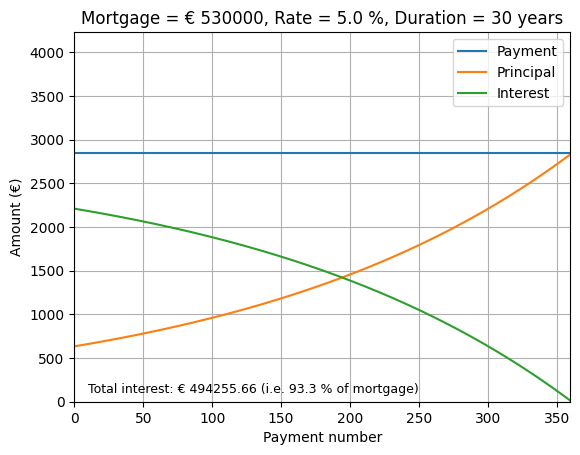

In [11]:
make_plot(df_annuity)

<Figure size 2000x1400 with 0 Axes>

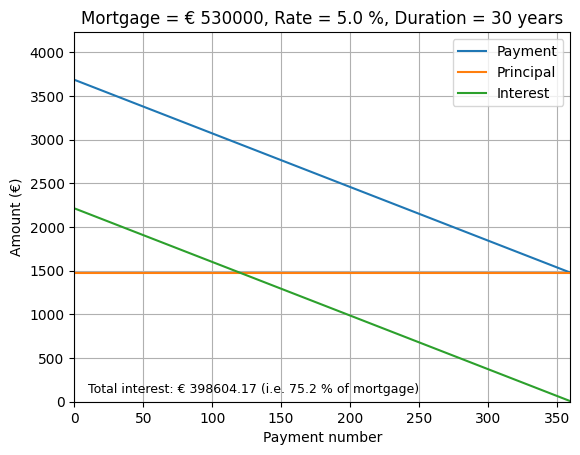

In [12]:
make_plot(df_linear)